# Experiment template
## The task is to predict number of lesions in the photo
***
### Content:
* [Settings and experiment parameters](#sep)
* [Load Data](#ld)
* [Learning and visualizing results](#lav)
* [Conclusions](#c)
***

#### Togle ON/OFF the raw code

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
CODE WAS HIDDEN. TO TOGGLE ON/OFF THE RAW CODE, CLICK
<a href="javascript:code_toggle()">here</a>.''')

---
<a name="sep"/>
# Settings and experiment parameters
</a>

### Global variables and paths 
* $\textbf{Add the main directory '.../code' to   sys.path}$. 

The following directory was added:

In [2]:
%load_ext autoreload
%autoreload 2
# %env THEANO_FLAGS="device=gpu1"

In [3]:
#### Add the main dir to sys ####

import os, sys

parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
print parentdir

sys.path.insert(0, parentdir)

/home/anastasia/cropDL/code


* $\textbf{Put your certain values or None}$ (then use run.ipynb to set them outside).

Note: In case you put None, files with parameters should be in the same directory with this .ipynb file 
(else change path_to_dir by what ever you want)


In [4]:
BATCH_SIZE,SEQ_LENGTH = 10,20
FILTER_SIZE = None
N_HIDDEN = None
TRAIN_NN = True

* $\textbf{Global parameters for this experiment:}$



In [5]:
# Read global params from files
import json

print "BATCH_SIZE = ", BATCH_SIZE
print "SEQ_LENGTH = ", SEQ_LENGTH

#WARN: where files with external parameters are stored
path_to_dir = '.'

if FILTER_SIZE is None:
    with open(os.path.join(path_to_dir,'filter_size.txt')) as data_file:    
        FILTER_SIZE = json.load(data_file)
print "FILTER_SIZE =", FILTER_SIZE   


if N_HIDDEN is None:
    with open(os.path.join(path_to_dir,'n_hidden.txt')) as data_file:    
        N_HIDDEN = json.load(data_file)
print "N_HIDDEN =", N_HIDDEN   

print "TRAIN_NN is", TRAIN_NN

BATCH_SIZE =  10
SEQ_LENGTH =  20
FILTER_SIZE = [3, 3]
N_HIDDEN = 30
TRAIN_NN is True


In [6]:
# description = {here could be a short description of the experiment}

# specific name of the experiment
eval_name = 'Test'

if eval_name is None:
    with open(path_to_dir+'eval_name.txt') as data_file:    
        eval_name = json.load(data_file)
print "eval_name is", eval_name 

eval_name is Test


In [7]:
from config import data_path_train, data_path_valid, results_path

# path to save the results for THIS experiment
results_eval_path = results_path + eval_name + "/"

In [8]:
##### IMPORTS ####

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


---
<a name='ld'/>
# Load Data
</a>

* Load and visualize data

In [9]:
train_set = np.load(data_path_train)
Y_train = train_set['y']
X_train = train_set['x']

In [10]:
valid_set = np.load(data_path_valid)
Y_valid = valid_set['y']
X_valid = valid_set['x']

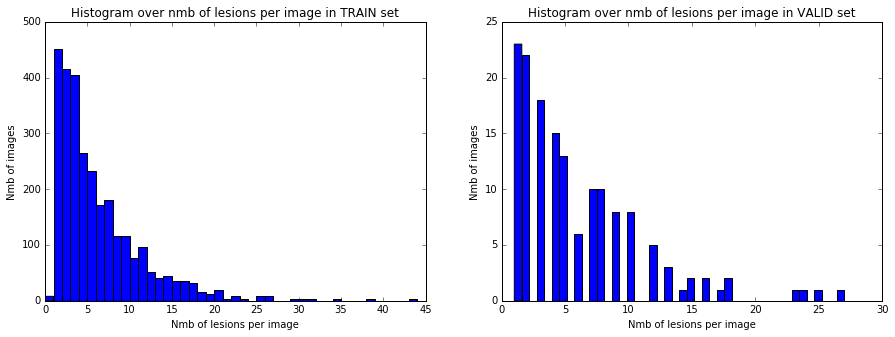

In [11]:
f,a = plt.subplots(1,2, figsize=(15,5))
a = a.ravel()

a[0].hist(Y_train, facecolor='blue', bins = np.max(Y_train))
a[0].set_title('Histogram over nmb of lesions per image in TRAIN set')
a[0].set_xlabel('Nmb of lesions per image')
a[0].set_ylabel('Nmb of images')

a[1].hist(Y_valid, facecolor='blue', bins = np.max(Y_train))
a[1].set_title('Histogram over nmb of lesions per image in VALID set')
a[1].set_xlabel('Nmb of lesions per image')
a[1].set_ylabel('Nmb of images')

---
<a name='lav'/>
# Learning and Visualizing
</a>

In [12]:
#### BATCH ITERATOR ####

from utils.generator import generator
gen_train = generator(X_train, Y_train, BATCH_SIZE)
gen_valid = generator(X_valid, Y_valid, BATCH_SIZE)

* $ \textbf{ Characteristics of input images and the input layer}$

In [13]:
#### PREPARE DATA FOR NN ####

import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer

nmb_channels, inp_shape = X_train[0].shape[0], X_train[0].shape[1:]
print 'Image shape', inp_shape
print "Number of channels:", nmb_channels

X_inp = T.tensor4()
X_layer = InputLayer([None, nmb_channels, inp_shape[0], inp_shape[1]],input_var=X_inp,name='input')

print "Input layer shape:", lasagne.layers.get_output_shape(X_layer)

Image shape (126, 193)
Number of channels: 3
Input layer shape: [None, 3, 126, 193]


* $ \textbf{ Characteristics of NN}$

In [14]:
#### LOAD NN ####

from models.CNNmodel import ClassiCNN as CNN
cnn = CNN(X_layer,n_hidden=N_HIDDEN,filter_size=FILTER_SIZE)

##weight sanity check
total_weights = int(T.sum([T.prod(w.shape) for w in cnn.weights]).eval())
print "Total weights:", total_weights

input_shape [None, 3, 126, 193]
Total weights: 39091


* $ \textbf{Objective loss, updates, train and eval fuctions}$

In [15]:
Y = T.vector('Target Y integer')
mae, mse,reg_l2 = cnn.get_loss_components(Y)

loss = mae + reg_l2

In [16]:
import lasagne
updates = lasagne.updates.adagrad(loss,cnn.weights, learning_rate=1e-2)

In [17]:
import theano
train_func = theano.function([X_inp,Y], [mae, mse,reg_l2], updates=updates)
eval_func = theano.function([X_inp, Y], [mae, mse,reg_l2])

In [18]:
import time
from visualizers.metrics import Metrics
metrics = Metrics()

def train_nn (N_EPOCHS):
    
    losses = []
    epoch = 1
    for i in range(N_EPOCHS):
        
        t0 = time.time()
#         print "iteration step..."
        x_batch, y_batch = gen_train.next()
#         print "time:", time.time() - t0
        t1 = time.time()
#         print "training..."        
        mae_i, mse_i, reg_i = train_func(x_batch,y_batch)
#         print "time:", time.time() - t1
        
        loss_i = mae_i + reg_i
        metrics["train loss"][epoch] = mae_i
        metrics["train full objective"][epoch] = loss_i
        metrics["train reg"][epoch] = reg_i
        losses.append(loss_i)


        if epoch%10==0:
            x_batch, y_batch = gen_valid.next()
            mae_i, mse_i, reg_i = eval_func(x_batch,y_batch)
            loss_i = mae_i + reg_i
            metrics["test loss"][epoch] = mae_i,
            metrics["test full objective"][epoch] = loss_i
            metrics["train reg"][epoch] = reg_i


        if epoch%10==0:
            print "epoch:",epoch
            print np.round(np.mean(losses[-10:]),3)
        if epoch%100==0:
            plt.figure(figsize=[15,5])
            metrics.plot()

        epoch+=1

    metrics.plot()

* $ \textbf{Train NN}$

N_EPOCHS =  1000
epoch: 10
6.711
epoch: 20
5.789
epoch: 30
4.717
epoch: 40
3.44
epoch: 50
4.012
epoch: 60
3.397
epoch: 70
4.16
epoch: 80
3.51
epoch: 90
3.81
epoch: 100
3.542


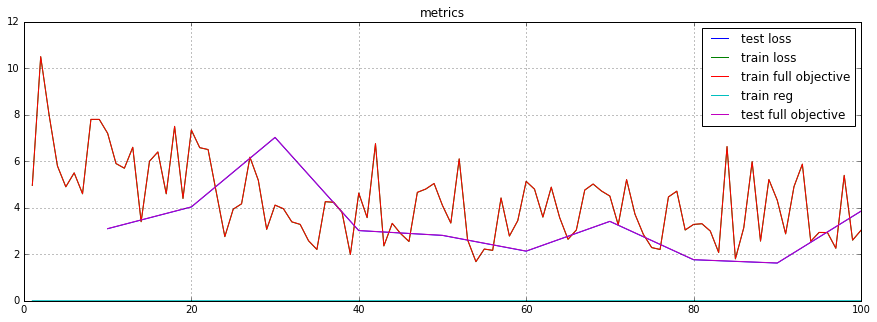

epoch: 110
3.182
epoch: 120
3.563
epoch: 130
3.751
epoch: 140
2.961
epoch: 150
3.888
epoch: 160
3.209
epoch: 170
3.056
epoch: 180
3.454
epoch: 190
3.038
epoch: 200
3.287


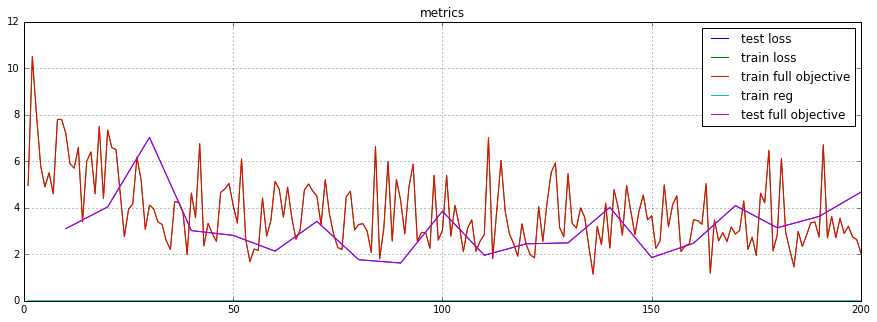

epoch: 210
2.429
epoch: 220
3.249
epoch: 230
3.141
epoch: 240
2.706
epoch: 250
3.114
epoch: 260
3.587
epoch: 270
2.872
epoch: 280
2.281
epoch: 290
2.367
epoch: 300
2.514


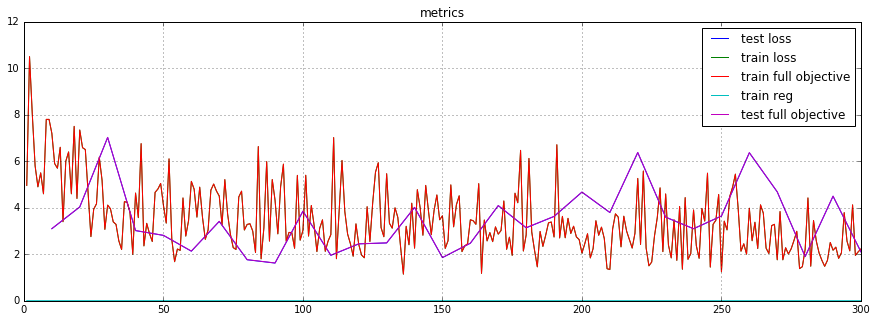

epoch: 310
2.553
epoch: 320
2.753
epoch: 330
2.424
epoch: 340
2.637
epoch: 350
3.165
epoch: 360
3.022
epoch: 370
2.631
epoch: 380
1.956
epoch: 390
3.375
epoch: 400
2.182


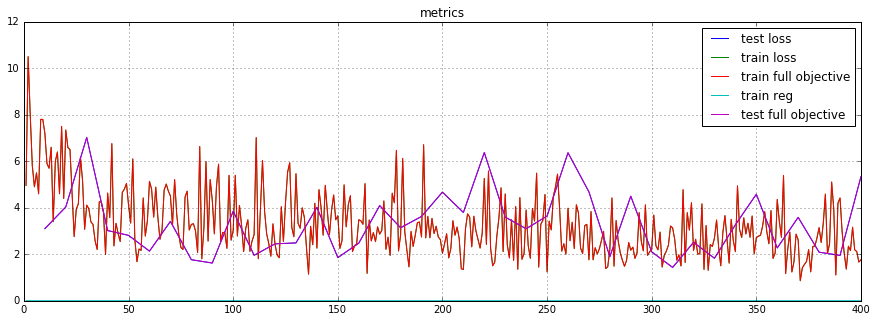

epoch: 410
3.401
epoch: 420
2.33
epoch: 430
1.923
epoch: 440
2.534
epoch: 450
2.563
epoch: 460
2.629
epoch: 470
2.197
epoch: 480
3.157
epoch: 490
2.562
epoch: 500
2.613


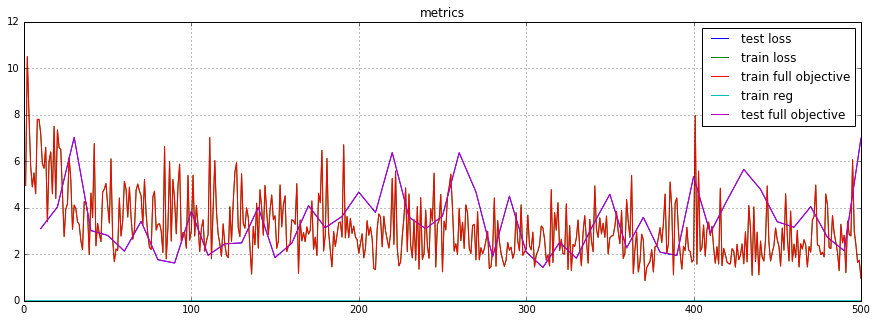

epoch: 510
2.803
epoch: 520
2.453
epoch: 530
2.519
epoch: 540
2.557
epoch: 550
2.188
epoch: 560
2.8
epoch: 570
2.324
epoch: 580
2.666
epoch: 590
2.395
epoch: 600
2.797


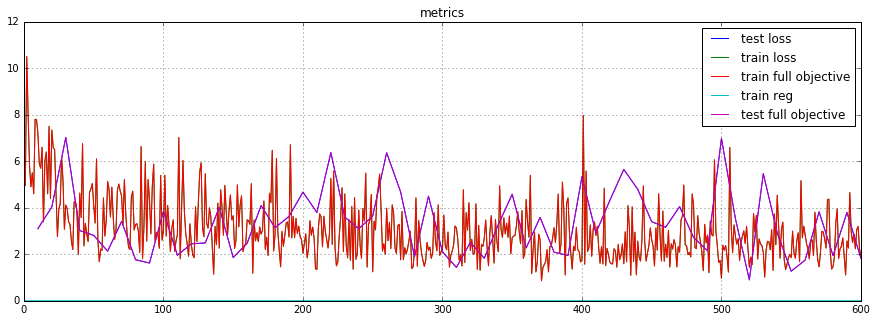

epoch: 610
2.185
epoch: 620
2.729
epoch: 630
2.57
epoch: 640
2.2
epoch: 650
2.365
epoch: 660
3.183
epoch: 670
2.133
epoch: 680
2.392
epoch: 690
2.496
epoch: 700
2.754


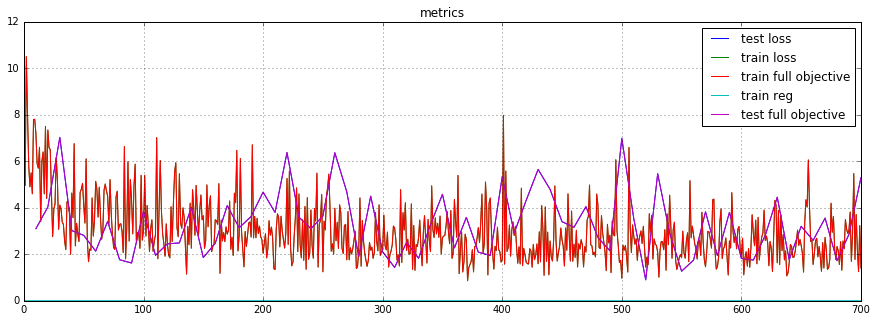

epoch: 710
2.732
epoch: 720
2.69
epoch: 730
2.199
epoch: 740
2.842
epoch: 750
2.232
epoch: 760
2.258
epoch: 770
2.885
epoch: 780
2.449
epoch: 790
2.447
epoch: 800
2.208


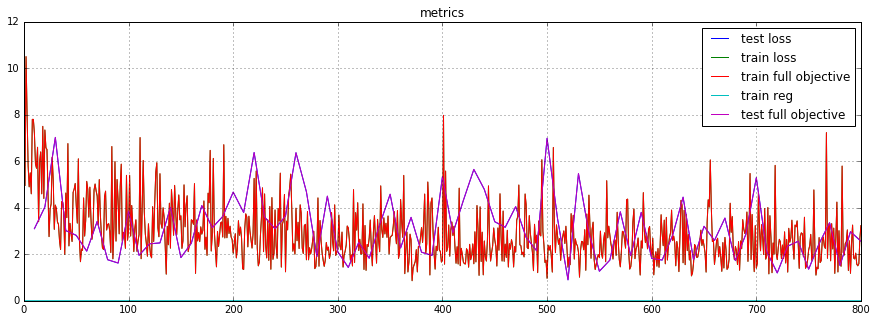

epoch: 810
2.344
epoch: 820
1.918
epoch: 830
2.375
epoch: 840
2.767
epoch: 850
2.964
epoch: 860
2.001
epoch: 870
2.457
epoch: 880
1.89
epoch: 890
2.31
epoch: 900
2.51


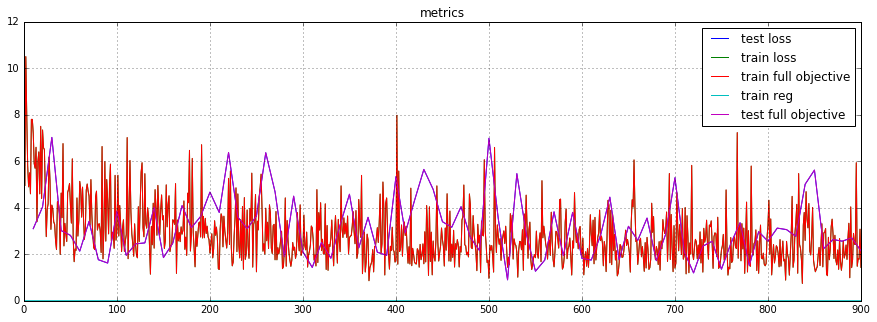

epoch: 910
2.492
epoch: 920
2.347
epoch: 930
2.509
epoch: 940
2.523
epoch: 950
2.54
epoch: 960
2.237
epoch: 970
2.322
epoch: 980
3.045
epoch: 990
2.241
epoch: 1000
2.148


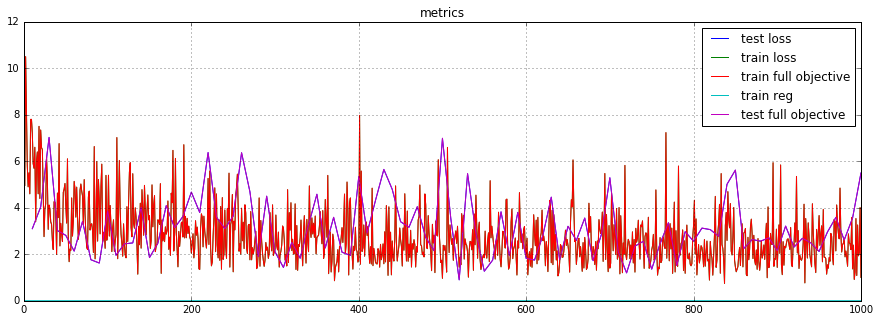

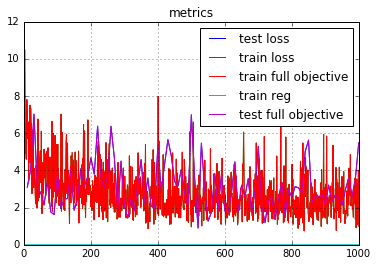

In [19]:
#### TRAIN NN ####

from utils.persistence import *

N_EPOCHS = 1000
print "N_EPOCHS = ", N_EPOCHS
nn_weights = results_eval_path + eval_name + "_weights.pickle"

if TRAIN_NN:
    train_nn(N_EPOCHS) 
else:
    try:
        a = load(cnn.cnn_out, nn_weights)
    except:
        print "problem with weights loading, nn is being trained"
        train_nn(N_EPOCHS) 

* $ \textbf{Save weights}$ 

In [20]:
from utils.persistence import *

if not os.path.exists(results_eval_path):
    os.makedirs(results_eval_path)
    
file_path = results_eval_path + eval_name + '_weights' + '.pickle'
save(cnn.cnn_out, file_path)

In [21]:
try:
    a = load(cnn.cnn_out, nn_weights)
except:
    print "The problem occured. Weights were not saved"
else: print 'Weights were successfully saved to the file: ', file_path

Weights were successfully saved to the file:  /home/anastasia/cropDL/code/results/Test/Test_weights.pickle


* $ \textbf{Visualizations}$ 

In [22]:
from visualizers.visualizer import Visualizer

N_BATCHES = 100

vis_train = Visualizer(model=cnn, generator=gen_train, n_batches=N_BATCHES,name='model train')
vis_valid = Visualizer(model=cnn, generator=gen_valid, n_batches=N_BATCHES,name='model valid')

In [23]:

vis_train_mse = vis_train.estimate_mse()
vis_train_mae = vis_train.estimate_mae()

vis_valid_mse = vis_valid.estimate_mse()
vis_valid_mae = vis_valid.estimate_mae()

print 'Number of batches to valid:', N_BATCHES
print 'train: mse = {}, mae = {}'.format(vis_train_mse, vis_train_mae)
print 'valid: mse = {}, mae = {}'.format(vis_valid_mse, vis_valid_mae)

Number of batches to valid: 100
train: mse = 16.5100236086, mae = 2.30292814307
valid: mse = 21.4158363505, mae = 3.06698028199


* $ \textbf{Save metrics results}$ 

In [24]:
file_path = results_eval_path + eval_name + ".pickle"
print "Path to save the results: ", file_path

if os.path.exists(file_path):
    os.remove(file_path)

if not os.path.exists(results_eval_path):
    os.makedirs(results_eval_path)

vis_train.save_results(file_path)
vis_valid.save_results(file_path)

Path to save the results:  /home/anastasia/cropDL/code/results/Test/Test.pickle


---
<a name='c'/>
# Conclusions
</a>